# Copernicus Sentinel-2 datasets

In [1]:
import numpy as np
import os
import sys
from osgeo import gdal, osr, ogr
import pathlib
import time
import rasterio
from rasterio.plot import show_hist
from rasterio.plot import show
import PIL
from PIL import Image, ImageDraw
from skimage import io
from skimage import exposure
from skimage.io import imread
import tifffile as tiff
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 
import zipfile
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [11]:
DATA_DIR = 'data'
sentinel2_data_file = 'S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE.zip'
dataset_name = sentinel2_data_file[:19]
dataset_name

'S2A_MSIL2A_20250823'

In [7]:
with ZipFile(f'{DATA_DIR}/{sentinel2_data_file}', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/{dataset_name}')

In [22]:
bands_folder = pathlib.Path(DATA_DIR + '/' + dataset_name)
bands_folder.name

'S2A_MSIL2A_20250823'

In [28]:
main_sub_folder = [pathlib.Path(x) for x in bands_folder.iterdir() if x.is_dir()][0]
main_sub_folder

WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE')

In [29]:
granule_folder = main_sub_folder.joinpath('GRANULE')
granule_folder

WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE')

In [31]:
tile_folder = [pathlib.Path(x) for x in granule_folder.iterdir() if x.is_dir()][0]
tile_folder

WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627')

In [34]:
img_folder = tile_folder.joinpath('IMG_DATA/R10m')
img_folder

WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m')

In [36]:
r10m_bands = [pathlib.Path(band) for band in img_folder.iterdir()]
r10m_bands

[WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m/T33SVA_20250823T094121_AOT_10m.jp2'),
 WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m/T33SVA_20250823T094121_B02_10m.jp2'),
 WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m/T33SVA_20250823T094121_B03_10m.jp2'),
 WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m/T33SVA_20250823T094121_B04_10m.jp2'),
 WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m/T33SVA_20250823T094121_B08_10m.jp2'),


In [37]:
def get_raster_attributes(img_path):
    width = 0.0
    height = 0.0
    d_type = None
    crs = None
    transform = None
    with rasterio.open(img_path) as dataset:
        d_types = dataset.dtypes[0]
        print('dtypes: {}'.format(d_types))
        print('Number of bands: {:d}'.format(dataset.count))
        width = dataset.width
        height = dataset.height
        print('Band width: {:d}, band height: {:d}'.format(width, height))
        transform = dataset.transform
        print('Dataset affine transform:\n {}'.format(transform))
        crs = dataset.crs
        print('EPSG Coordinates Reference System: {}'.format(crs))
        bb_left = dataset.bounds.left
        bb_bottom = dataset.bounds.bottom
        bb_right = dataset.bounds.right
        bb_top = dataset.bounds.top
        print('Bounding box \n left: {:.2f}, \n bottom: {:.2f}, \n right: {:.2f}, \n top: {:.2f}'.format(bb_left, bb_bottom, bb_right, bb_top))                                                   
    return width, height, d_type, transform

In [38]:
b2_band = r10m_bands[1]
b2_band

WindowsPath('data/S2A_MSIL2A_20250823/S2A_MSIL2A_20250823T094121_N0511_R036_T33SVA_20250823T115213.SAFE/GRANULE/L2A_T33SVA_A053115_20250823T094627/IMG_DATA/R10m/T33SVA_20250823T094121_B02_10m.jp2')

In [39]:
get_raster_attributes(b2_band)

dtypes: uint16
Number of bands: 1
Band width: 10980, band height: 10980
Dataset affine transform:
 | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4100040.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: EPSG:32633
Bounding box 
 left: 399960.00, 
 bottom: 3990240.00, 
 right: 509760.00, 
 top: 4100040.00


(10980,
 10980,
 None,
 Affine(10.0, 0.0, 399960.0,
        0.0, -10.0, 4100040.0))

In [40]:
def get_image_array(img_path):
    '''
    This function returns a NumPy array
    of the image. For one band it returns 
    a 2D array with shape (height, width).
    For a RGB image with three bands it 
    returns a 3D array with shape (channels, height, width) 
    '''
    with gdal.Open(img_path) as image_ds:
        image_array = image_ds.ReadAsArray()
    return image_array

In [42]:
b2_band_array = get_image_array(b2_band)
b2_band_array.shape

(10980, 10980)

In [49]:
b2_band_array.min()

0

In [50]:
b2_band_array.max()

19760

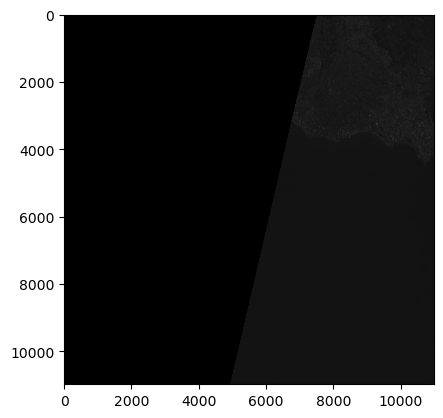

In [48]:
plt.imshow(b2_band_array, cmap='gray')